In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.stats import norm

import policy_time as pt

In [105]:
def make_stat_mats(df):
    # Inner func does most of the work querying for each obs.
    # Returns everything at once: 
    #   r_mat[12,12,2], b_mat[12,12,2], h_mat[12,12,2], counts[12,12].

    def get_stats_angs(df, obs):
        # Gets mean and var of df values that match obs, centered on obs
        # Returns r_stats, b_stats, h_stats, count. The first three are tuples [mu,var].

        df_d = dict(zip(df.columns,range(len(df.columns))))
        series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])).copy()
        series.iloc[:,df_d['next_obs_b']] = wrap_correct(series['next_obs_b'].to_numpy(),ref=series['obs_b'].to_numpy(),buffer=180)
        series.iloc[:,df_d['next_obs_h']] = wrap_correct(series['next_obs_h'].to_numpy(),ref=series['obs_h'].to_numpy(),buffer=180)

        # Handles case for one sample (initialize)
        r_sts,b_sts,h_sts,count = [np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan],0
        if series.size > 0:    
            r_sts[0],b_sts[0],h_sts[0] = wrap_correct(series['reward'].mean(),buffer=None), \
                                            wrap_correct(series['next_obs_b'].mean(),buffer=180), \
                                            wrap_correct(series['next_obs_h'].mean(),buffer=180)
            if series.size > 1:
                r_sts[1],b_sts[1],h_sts[1] = series['reward'].var(), \
                                                series['next_obs_b'].var(), \
                                                series['next_obs_h'].var()
        return r_sts,b_sts,h_sts,series.size


    r_mat = np.zeros((12,12,2)) + np.nan 
    b_mat = np.zeros((12,12,2)) + np.nan 
    h_mat = np.zeros((12,12,2)) + np.nan 
    counts = np.zeros((12,12))

    for i,theta_b in enumerate(np.arange(-180,180,30)):
        for j,theta_h in enumerate(np.arange(-180,180,30)):
            r_sts,b_sts,h_sts,counts[i,j] = get_stats_angs(df,[theta_b,theta_h])
            r_mat[i,j,:] = r_sts
            b_mat[i,j,:] = b_sts
            h_mat[i,j,:] = h_sts

    return r_mat, b_mat, h_mat, counts

def wrap_correct(arr_orig,ref=0,buffer=180):
    # Takes angles and translates them to +/-buffer around ref.
    # For things like std, use large buffer so it doesn't change
    # If both arrays, send each element through this function.
    if buffer is None:
        return arr_orig
    
    if hasattr(arr_orig,"__len__"):
        arr = arr_orig.copy()
        if hasattr(ref,"__len__"):
            for i in range(len(arr)):
                arr[i] = wrap_correct(arr[i],ref=ref[i],buffer=buffer)
        # If only arr is an array
        else:
            arr[arr<ref-buffer]+=buffer*2
            arr[arr>=ref+buffer]-=buffer*2
            if len(arr[arr<ref-buffer])>0 or len(arr[arr>=ref+buffer])>0:
                arr = wrap_correct(arr,ref=ref,buffer=buffer)
    else:
        arr = arr_orig
        if arr<ref-buffer:
            arr+=buffer*2
            if arr<ref-buffer:
                arr = wrap_correct(arr,ref=ref,buffer=buffer)
        elif arr>=ref+buffer:
            arr-=buffer*2
            if arr>=ref+buffer:
                arr = wrap_correct(arr,ref=ref,buffer=buffer)
    return arr

def entropy(probs):
    return -probs*np.log(probs+1e-6)-(1-probs)*np.log(1-probs+1e-6)
def POver0(mu,sig):
    # Returns the probability that the RV is above 0
    # Lambda function returns elementwise
    return 1-norm.cdf(-mu/sig)

def get_bart_stats(bart):
    # Takes output of bart or sbart from R.
    b_diff = bart[:,1::2] - bart[:,::2]
    b_mu = np.mean(b_diff,axis=0).reshape(12,12)
    b_std = np.std(b_diff,axis=0).reshape(12,12)
    return b_diff,b_mu,b_std

def lin_interp_mat(mat,ang,wraparound=True):
    # Fills in NaNs in matrix by linear interpolation. 
    # ang is a boolean (True if data are for angles)
    # Only considers nearest neighbors (no diagonals).
    # Fills in NaNs from most neighbors to least neighbors.
    # wraparound extends matrix in all four directions. 
    if ang:
        buffer=180
    else:
        buffer=1e6

    mat = make_wraparound(mat,ang,wraparound=wraparound)

    # Find nans in relevant matrix section
    nan_inds = np.argwhere(np.isnan(mat[1:-1,1:-1])) + 1
        # add 1 because need index for extended matrix
    
    neighbor_lim = 3
    while nan_inds.size>0: 
        candidates = 0
        for ind in nan_inds:
            neighbors = get_neighbors(mat,ind)
            if sum(~np.isnan(neighbors)) >= neighbor_lim:
                mat[ind[0],ind[1]] = np.mean(wrap_correct(neighbors[~np.isnan(neighbors)], ref=min(neighbors), buffer=buffer))
                candidates+=1
        if candidates==0:
            neighbor_lim-=1
        nan_inds = np.argwhere(np.isnan(mat[1:-1,1:-1])) + 1

    return wrap_correct(mat[1:-1,1:-1],buffer=buffer)

def smoothen(matrix,counts,ang,smooth_par=.05,iters=30,wraparound=True,diagonals=True): 
    # matrix is in form [12,12]
    # counts is [12,12].
    # ang is bool, True if angle matrix
    # Will start with a simple weighted average between nearest neighbors and diagonals.
    #
    # Derivation for procedure in CL's nb page 81
    
    if np.array_equal(matrix,counts):
        count_version = True
    else:
        count_version = False
        
    if not np.all(counts):
        counts+=1
    # So the shapes start out right before looping 
    matrix = make_wraparound(matrix, ang, wraparound=True)
    counts = make_wraparound(counts, False, wraparound=True)
    if ang:
        buffer=180
    else:
        buffer=None
    
    for it in range(iters):
        matrix = make_wraparound(matrix[1:-1,1:-1], ang, wraparound=True)
        tempmat = np.copy(matrix) # Now tempmat and matrix are the same extended size
        rows,cols = np.array(matrix.shape)-2 

        # Loops through each matrix element and weights changes by counts
        for i in np.arange(rows)+1:
            for j in np.arange(cols)+1:
                neighs = wrap_correct(get_neighbors(matrix,(i,j)), ref=matrix[i,j], buffer=buffer)
                neigh_counts = get_neighbors(counts,(i,j))
                prod_nn = np.sum(np.multiply(neigh_counts, neighs))
                c_nn = np.sum(neigh_counts)
                
                if diagonals:
                    # Diagonal entries (scaled by 1/sqrt(2))
                    neighs_d = wrap_correct(get_diags(matrix,(i,j)), ref=matrix[i,j], buffer=buffer)
                    neigh_counts_d = get_diags(counts,(i,j))
                    prod_d = np.sum(np.multiply(neigh_counts_d, neighs_d))
                    c_d = np.sum(neigh_counts_d)
                    
                    mu = (prod_nn/c_nn + prod_d/(np.sqrt(2)*c_d)) / (1+1/np.sqrt(2))
                    alpha = 1/(1+(counts[i,j]*(1+1/np.sqrt(2)))/(c_nn/4+c_d/(4*np.sqrt(2))))
                    
                else:
                    mu = prod_nn/c_nn
                    alpha = 1/(1+(4*counts[i,j]/c_nn))
                    
                tempmat[i,j] = tempmat[i,j] + smooth_par*alpha*(mu - tempmat[i,j])
            
                
        # After tempmat is updated, set reference matrix to be the same
        # This way updates within one iteration don't get included in the same iteration
        matrix = np.copy(tempmat)
        if not count_version:
            counts = smoothen(counts,counts,False,smooth_par=smooth_par,iters=1)
    
    return wrap_correct(matrix[1:-1,1:-1], buffer=buffer)

def make_wraparound(mat,ang,wraparound=True):
    # Expands matrix for wraparound interpolation
    # If matrix is angle values, set ang=True.
    mat_new = np.zeros((np.array(mat.shape)+2)) + np.nan
    mat_new[1:-1,1:-1] = mat
    if ang:
        buffer=180
    else:
        buffer=None

    if wraparound:
        # diagonals
        mat_new[0,0] = wrap_correct(mat[-1,-1], ref=mat[0,0], buffer=buffer)
        mat_new[0,-1] = wrap_correct(mat[-1,0], ref=mat[0,-1], buffer=buffer)
        mat_new[-1,0] = wrap_correct(mat[0,-1], ref=mat[-1,0], buffer=buffer)
        mat_new[-1,-1] = wrap_correct(mat[0,0], ref=mat[-1,-1], buffer=buffer)
        # adjacents
        mat_new[0,1:-1] = wrap_correct(mat[-1,:], ref=mat[0,:], buffer=buffer)
        mat_new[-1,1:-1] = wrap_correct(mat[0,:], ref=mat[-1,:], buffer=buffer)
        mat_new[1:-1,0] = wrap_correct(mat[:,-1], ref=mat[:,0], buffer=buffer)
        mat_new[1:-1,-1] = wrap_correct(mat[:,0], ref=mat[:,-1], buffer=buffer)
    return mat_new

def get_neighbors(mat,i):
    # Makes array of four neighbors around mat[index]
    # index is a pair
    return np.array([mat[i[0],i[1]-1], mat[i[0],i[1]+1], mat[i[0]-1,i[1]], mat[i[0]+1,i[1]]])

def get_diags(mat,i):
    return np.array([mat[i[0]-1,i[1]-1], mat[i[0]-1,i[1]+1], mat[i[0]+1,i[1]-1], mat[i[0]+1,i[1]+1]])

def myround(x, base=30):
    return base * round(x/base)

def make_dist_dict2(df, sm_pars=None,
    prev_act_window=3,
    lp_frac=None):
    # This version doesn't smooth reward matrices. First subtracts them and then smooths the resulting matrix.
    # Stores difference in r_on and adds variances; sets r_off to 0's. 
    # Makes a dictionary of distributions using trajectory statistics.
    # sm_pars is a dict of form {'lambda': .05, 'iters': 30}
    #     If None, then no smoothing.
    # Lp_frac: [0,1]. Models find a number to subtract from light-on matrices, in order for
    #  this fraction of observations to remain above their corresponding light-off spots.

    traj_on = df.query('prev_actions=='+str(prev_act_window))
    traj_off = df.query('prev_actions==0')

    r_on, b_on, h_on, count_on = make_stat_mats(traj_on)
    r_off, b_off, h_off, count_off = make_stat_mats(traj_off)

    all_mats = [r_on,b_on,h_on,r_off,b_off,h_off]
    counts = [count_on,count_off]
    counts_lp = counts[0]+counts[1]

    for i in [1,2,4,5]:
        for j in range(2):
            if j==1:
                ang_par = False 
            else:
                ang_par = True
            all_mats[i][:,:,j] = lin_interp_mat(all_mats[i][:,:,j], ang_par)
            
            if sm_pars is not None:
                all_mats[i][:,:,j] = smoothen(all_mats[i][:,:,j], 
                                                counts[i//3], ang_par, 
                                                smooth_par=sm_pars['lambda'], iters=sm_pars['iters'])
                
    # Turns r_on and r_off matrices into their differences stored in r_on. (r_off is now set to 0)
    r_on[:,:,0] = r_on[:,:,0]-r_off[:,:,0]
    r_on[:,:,1] = r_on[:,:,1]+r_off[:,:,1]
    for i in range(2):
        r_on[:,:,i] = lin_interp_mat(r_on[:,:,i], False)
    r_on[:,:,0] = smoothen(r_on[:,:,0], counts_lp, False, smooth_par=sm_pars['lambda']*5, iters=sm_pars['iters'])
    r_off = np.zeros(r_off.shape)
    
    # This block is for light penalty implementation. Only applied to r_on.
    if lp_frac is None:
        light_penalty = 0
    else:
        r_diffs = r_on[:,:,0]-r_off[:,:,0]
        r_diffs_sorti = np.unravel_index(np.argsort(-r_diffs,axis=None), r_on[:,:,0].shape) # Subtract means and gets sorted indices.
        r_diffs_sorted = r_diffs[r_diffs_sorti]
        #counts_lp = np.ones((12,12)) ############
        count_lim = np.sum(counts_lp)*lp_frac
        cs = np.cumsum(counts_lp[r_diffs_sorti]) < count_lim
        cutoff_ind = [i for i,x in enumerate(cs) if not x][0]
        light_penalty = r_diffs_sorted[cutoff_ind]
        print(f'Penalty {light_penalty}')

    dist_dict = {
        'body_on': b_on,
        'body_off': b_off,
        'head_on': h_on,
        'head_off': h_off,
        'reward_on': r_on - light_penalty,
        'reward_off': r_off,
    }    
    return dist_dict

def plot_bart_results(bart_type,inds,folder,fname=None):

    fig,axs = plt.subplots(len(inds),6)
    fig.set_size_inches((18,3*len(inds)))

    with open(f'{folder}fulltraj.pkl','rb') as f:
        df = pickle.load(f)
    
    for i,ax in enumerate(axs):
        ind = inds[i]
        traj = np.load(f'{folder}traj{ind}.npy')
        ents = np.load(f'{folder}ents{ind}.npy')
        probs = np.load(f'{folder}probs{ind}.npy')
        bart = np.load(f'{folder}{bart_type}{ind}.npy')
        bartsig = np.load(f'{folder}bartsig{ind}.npy')
        with open(f'{folder}traj{ind}.pkl','rb') as f:
            trajdict = pickle.load(f)

        b_d,b_m,b_s = get_bart_stats(bart)
        ents,probs = pt.bart2pols(bart,bartsig)

        img = ax[0].imshow(np.mean(ents,axis=0).reshape(12,12))
        plt.colorbar(img,ax=ax[0])
        ax[0].set_title('Entropy');

        img = ax[1].imshow(pt.get_counts(df))
        plt.colorbar(img,ax=ax[1])
        ax[1].set_title('Counts')

        img = ax[2].imshow(b_m)
        plt.colorbar(img,ax=ax[2])
        ax[2].set_title('Mean Qdel');

        img = ax[3].imshow(b_s)
        plt.colorbar(img,ax=ax[3])
        ax[3].set_title('Std Qdel')

        img = ax[4].imshow(np.mean(probs,axis=0).reshape(12,12))
        plt.colorbar(img,ax=ax[4])
        ax[4].set_title('P(Qdel>0)')

        img = ax[5].imshow(np.round(np.mean(probs,axis=0)).reshape(12,12))
        ax[5].set_title('Best reward policy')

        [a.set_xticks([]) for a in ax]
        [a.set_yticks([]) for a in ax];
        [a.set_xlabel('Head angle') for a in ax]
    
    [axs[i,0].set_ylabel('Body angle') for i in range(len(inds))]
    if fname is not None: fig.savefig(fname)

In [211]:
folder = '../03_24_fixImgs/Data/03_29_3/'
#'../03_24_fixImgs/Data/03_28_0/'
# '../03_16_policyTime/Data/03_19_0/'

ind = 9

traj = np.load(f'{folder}traj{ind}.npy')
ents = np.load(f'{folder}ents{ind}.npy')
pol = np.load(f'{folder}pol{ind}.npy')
probs = np.load(f'{folder}probs{ind}.npy')
bart = np.load(f'{folder}bart{ind}.npy')
bart_s = np.load(f'{folder}bartsig{ind}.npy')

with open(f'{folder}fulltraj.pkl','rb') as f:
    trajdict = pickle.load(f)

In [142]:
traj

array([[ 9.        ,  5.        , 11.82932264,  1.        ],
       [ 9.        ,  7.        , 12.35246841,  1.        ],
       [ 8.        ,  9.        , 10.50659342,  1.        ],
       ...,
       [ 5.        ,  9.        ,  2.11746757,  0.        ],
       [ 5.        ,  9.        ,  2.43623986,  0.        ],
       [ 5.        ,  9.        ,  1.75756048,  0.        ]])

In [162]:
trajdict

,loc,next_obs_b,next_obs_h,obs_b,obs_h,prev_actions,reward,t
0,"[783.7142857216087, 755.1666666828042]",150.0,-60.0,150.0,-60.0,0.0,-15.224855,0.360
1,"[782.6415094446073, 756.3962264223329]",150.0,30.0,150.0,30.0,3.0,-15.959555,0.875
2,"[782.2884615509354, 757.0192307737426]",120.0,60.0,150.0,30.0,3.0,-16.156405,1.063
3,"[781.8653846298048, 757.6730769245809]",120.0,60.0,120.0,60.0,3.0,-15.876603,1.235
4,"[781.8333333491149, 757.8125000009344]",150.0,60.0,120.0,60.0,3.0,-15.826923,1.407
...,...,...,...,...,...,...,...,...
16436,"[821.3636363339815, 1534.0]",60.0,-60.0,60.0,-30.0,0.0,7.211111,174.188
16437,"[820.9090908893211, 1534.3636363557284]",60.0,-60.0,60.0,-60.0,0.0,6.304813,174.359
16438,"[820.999999970098, 1534.499999985049]",60.0,0.0,60.0,-60.0,0.0,6.194805,174.547
16439,"[821.4999999700981, 1534.0]",30.0,30.0,60.0,0.0,0.0,7.266667,174.719


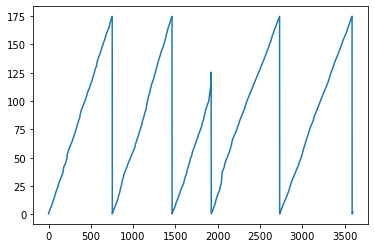

In [166]:
plt.plot(trajdict['t'][:3600])

In [167]:
trajdict = trajdict[:3600]

In [212]:
r,b,h,counts = make_stat_mats(trajdict)

# 3.28.0

In [213]:
bd,bmu,bsig = get_bart_stats(bart)

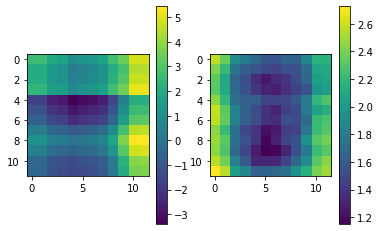

In [59]:
fig,ax = plt.subplots(1,2)
b_st = [bmu,bsig]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])

In [86]:
traj = traj[355:,:3]

In [87]:
np.save('trajtest.npy',traj)

In [95]:
bart0 = np.load(f'{folder}barttest.npy')

In [97]:
bmu0,bsig0 = np.mean(bart0,axis=0).reshape(12,12), np.std(bart0,axis=0).reshape(12,12)

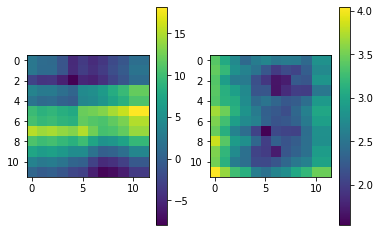

In [93]:
fig,ax = plt.subplots(1,2)
b_st = [bmu1,bsig1]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])

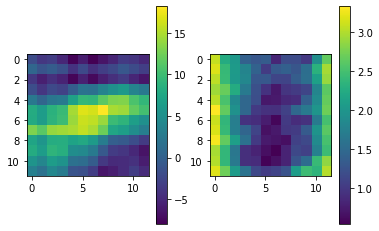

In [98]:
fig,ax = plt.subplots(1,2)
b_st = [bmu0,bsig0]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])

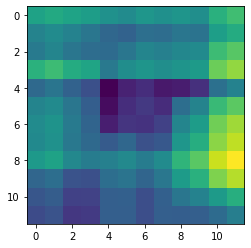

In [99]:
plt.imshow(bmu1-bmu0)

In [173]:
traj_on = trajdict[trajdict['prev_actions']==3]
traj_off = trajdict[trajdict['prev_actions']==0]

In [174]:
r_on,_,_,_ = make_stat_mats(traj_on)
r_off,_,_,_ = make_stat_mats(traj_off)

In [181]:
counts = pt.get_counts(trajdict)

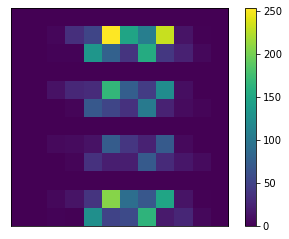

In [183]:
plt.imshow(counts)
plt.colorbar();
plt.xticks([])
plt.yticks([]);

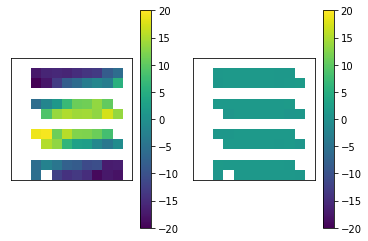

In [184]:
# Light off
fig,ax = plt.subplots(1,2)
r = r_off
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i],vmin=-20,vmax=20)
    plt.colorbar(img,ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

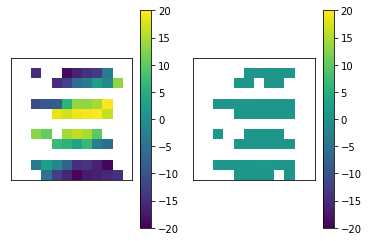

In [187]:
# Light on
fig,ax = plt.subplots(1,2)
r = r_on
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i],vmin=-20,vmax=20)
    plt.colorbar(img,ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# The data are indeed bad

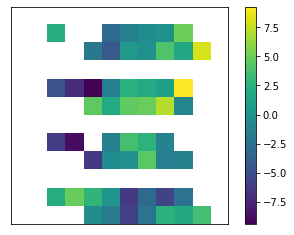

In [186]:
plt.imshow((r_on - r_off)[:,:,0])
plt.colorbar();
plt.xticks([])
plt.yticks([]);

## But with smoothing? Still bad. 

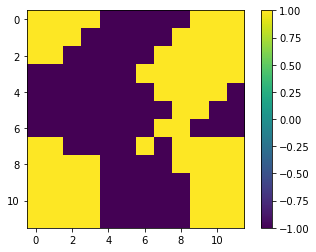

In [207]:
plt.imshow(np.sign(dist['reward_on'][:,:,0]))
plt.colorbar();

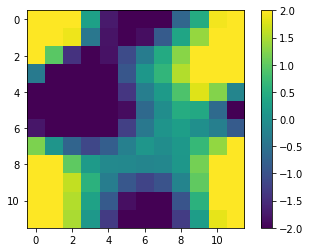

In [208]:
plt.imshow(dist['reward_on'][:,:,0],vmin=-2,vmax=2)
plt.colorbar();

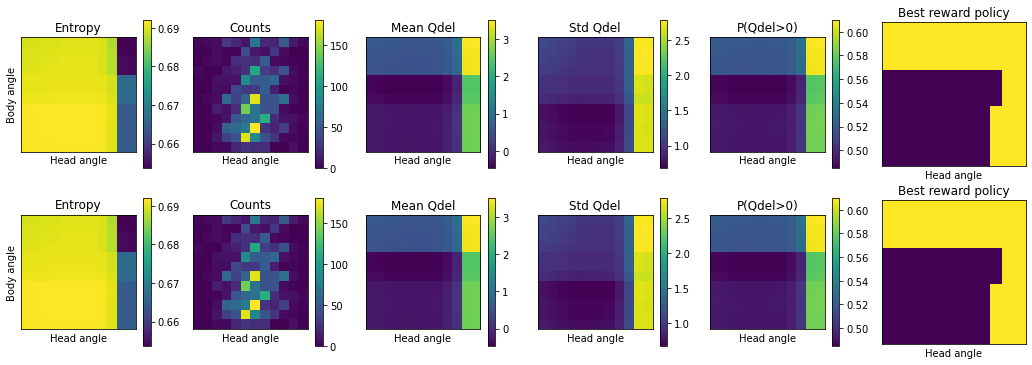

In [221]:
# 50 trees, power=4,base=.95
plot_bart_results('bartn',[9,9],'./Data/03_28_0/')
# Varprob.mean
# 0.149, 0.5, 0.351

# the good dataset from 3.19.0

In [81]:
counts = pt.get_counts(trajdict)

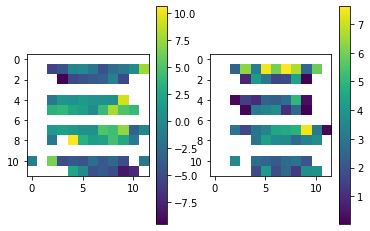

In [72]:
# Light off
fig,ax = plt.subplots(1,2)
r = r_off
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i])
    plt.colorbar(img,ax=ax[i])

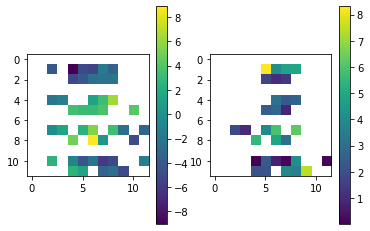

In [73]:
# Light on
fig,ax = plt.subplots(1,2)
r = r_on
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i])
    plt.colorbar(img,ax=ax[i])

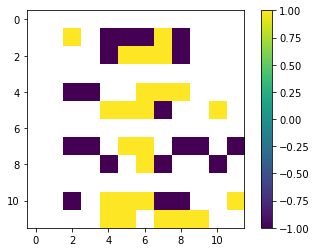

In [92]:
plt.imshow(np.sign((r_on - r_off)[:,:,0]))
plt.colorbar();

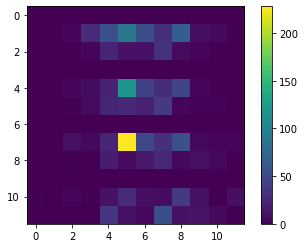

In [85]:
plt.imshow(counts)
plt.colorbar();

# Testing smoothing method just to see

In [153]:
dist.keys()

dict_keys(['body_on', 'body_off', 'head_on', 'head_off', 'reward_on', 'reward_off'])

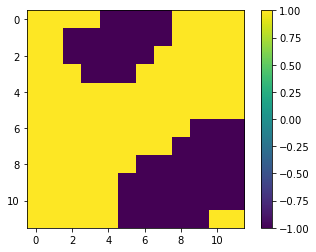

In [155]:
plt.imshow(np.sign(dist['reward_on'][:,:,0]))
plt.colorbar();

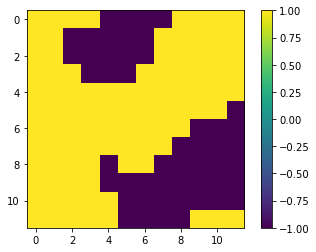

In [143]:
plt.imshow(np.sign(dist['reward_on'][:,:,0]))
plt.colorbar();

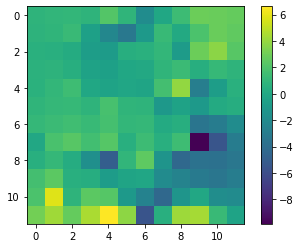

In [231]:
plt.imshow(dist['reward_on'][:,:,0])#,vmin=-2,vmax=2)
plt.colorbar();

[[<matplotlib.lines.Line2D at 0x2f40309a4c0>],

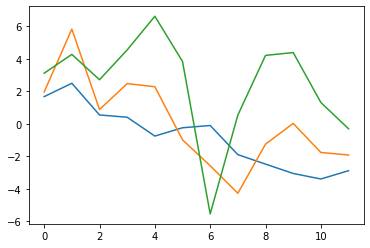

In [235]:
[plt.plot(dist['reward_on'][i,:,0]) for i in [9,10,11]]

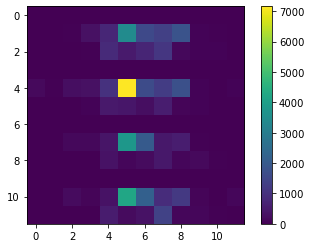

In [174]:
plt.imshow(counts)
plt.colorbar();

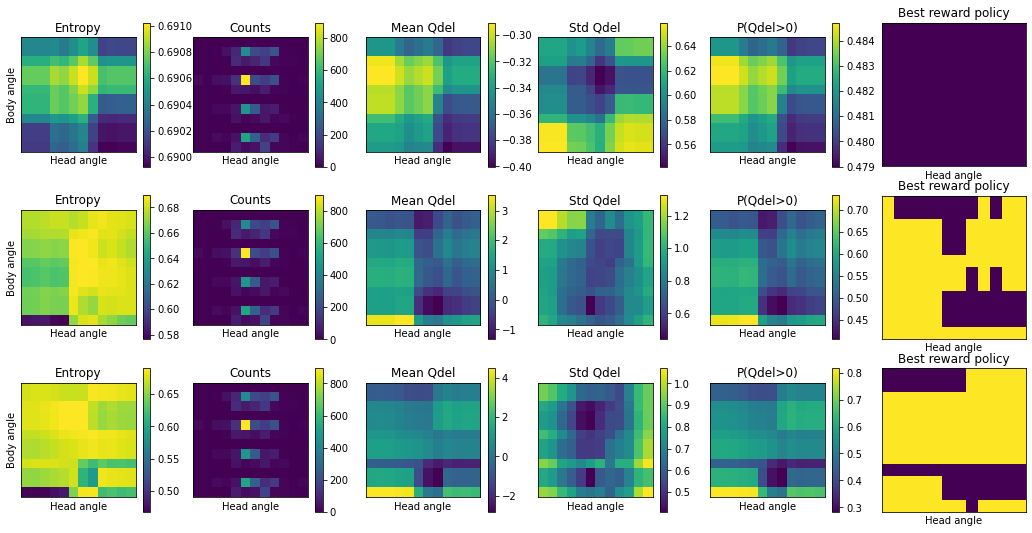

In [160]:
plot_bart_results('bart',[0,4,9],'../03_16_policyTime/Data/03_19_0/')

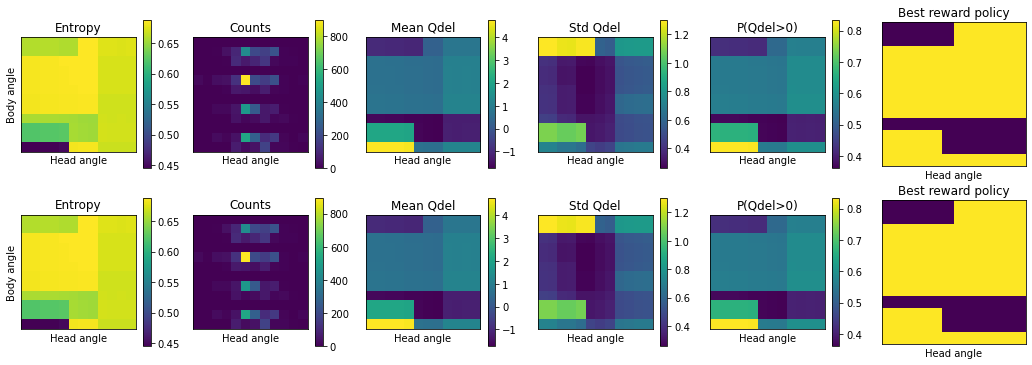

In [217]:
# 50 trees, power=4,base=.95
plot_bart_results('bartn',[9,9])

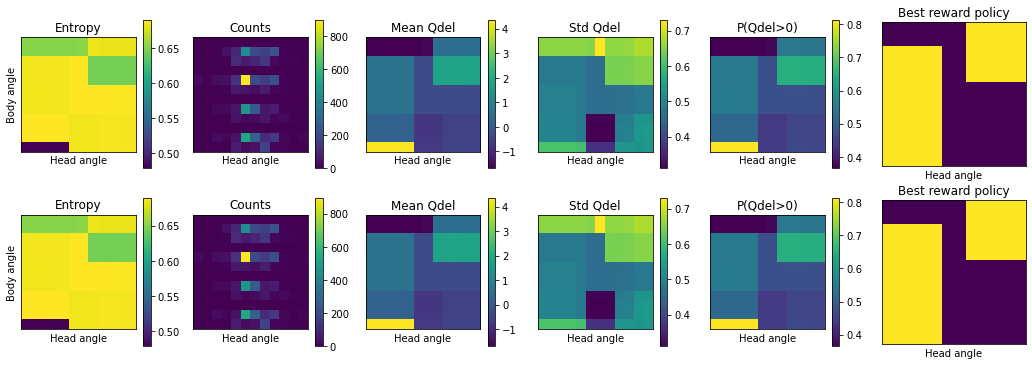

In [215]:
# 20 trees, power=4,base=.95
plot_bart_results('bartn',[9,9])

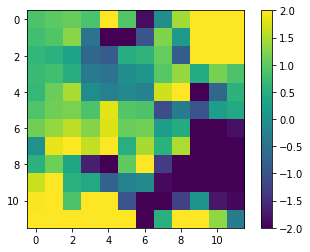

In [241]:
plt.imshow(dist['reward_on'][:,:,0],vmin=-2,vmax=2)
plt.colorbar();

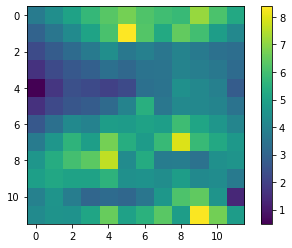

In [240]:
plt.imshow(np.sqrt(dist['reward_on'][:,:,1]))
plt.colorbar();

# 3.19.1

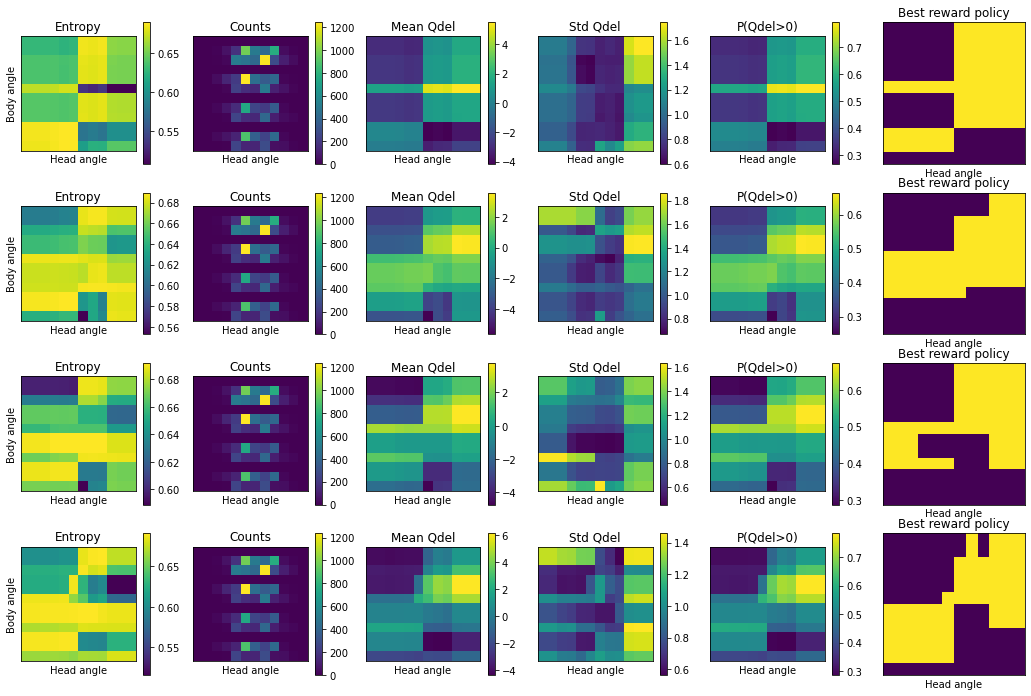

In [180]:
plot_bart_results('bart',[4,9,14,19])

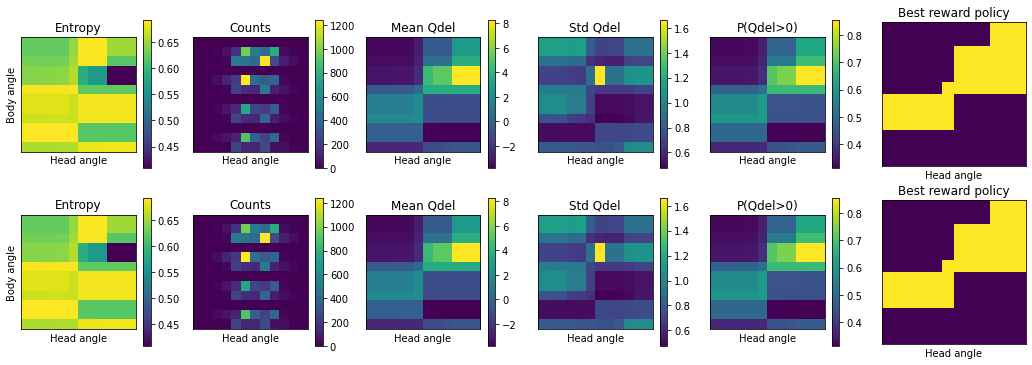

In [193]:
# 50 trees
plot_bart_results('bartn',[19,19])

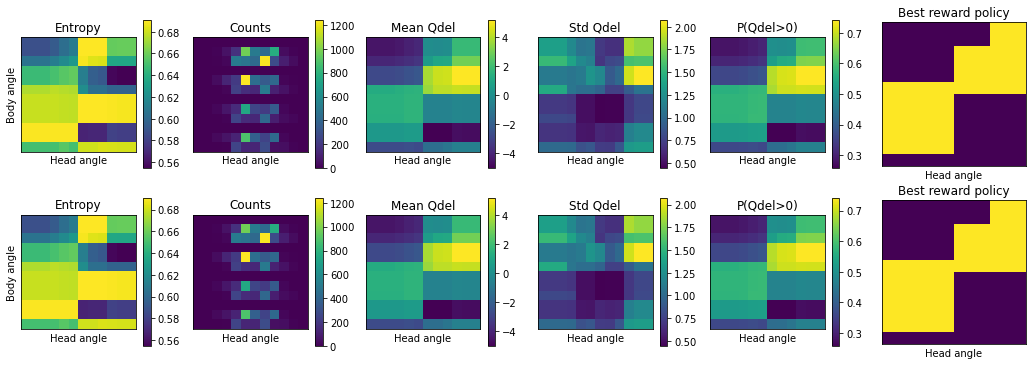

In [194]:
# 20 trees
plot_bart_results('bartn',[19,19])

In [202]:
dist = make_dist_dict2(trajdict,sm_pars = {'lambda':.1,'iters':10})

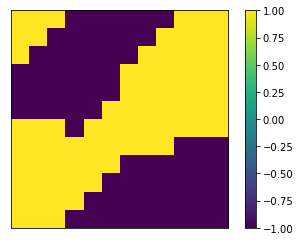

In [205]:
plt.imshow(np.sign(dist['reward_on'][:,:,0]))
plt.colorbar();
plt.xticks([])
plt.yticks([]);

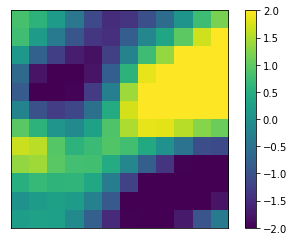

In [206]:
plt.imshow(dist['reward_on'][:,:,0],vmin=-2,vmax=2)
plt.colorbar();
plt.xticks([]);
plt.yticks([]);

# No processing

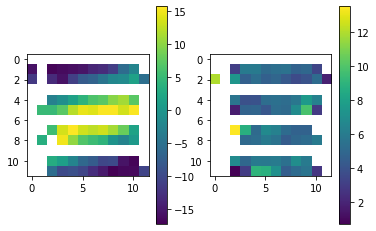

In [189]:
# Light off
fig,ax = plt.subplots(1,2)
r = r_off
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i])
    plt.colorbar(img,ax=ax[i])

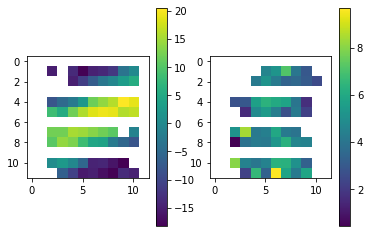

In [190]:
# Light on
fig,ax = plt.subplots(1,2)
r = r_on
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i])
    plt.colorbar(img,ax=ax[i])

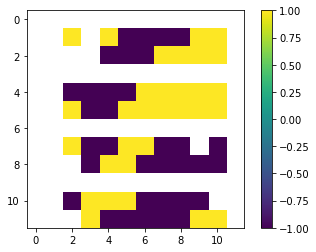

In [191]:
plt.imshow(np.sign((r_on - r_off)[:,:,0]))
plt.colorbar();

# Lab meeting plots

## 3.29.0

In [5]:
bd,bmu,bsig = get_bart_stats(bart)

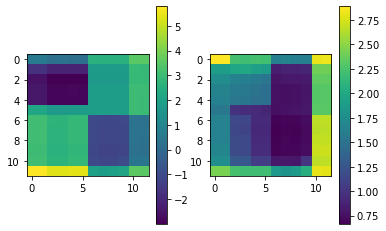

In [6]:
fig,ax = plt.subplots(1,2)
b_st = [bmu,bsig]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])

In [7]:
traj_on = trajdict[trajdict['prev_actions']==3]
traj_off = trajdict[trajdict['prev_actions']==0]

In [8]:
r_on,_,_,_ = make_stat_mats(traj_on)
r_off,_,_,_ = make_stat_mats(traj_off)

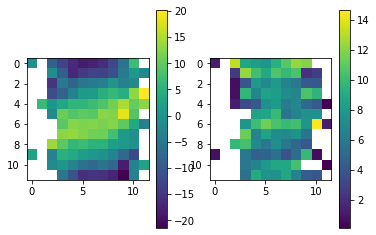

In [9]:
# Light off
fig,ax = plt.subplots(1,2)
r = r_off
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i])
    plt.colorbar(img,ax=ax[i])

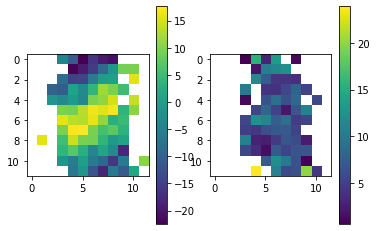

In [10]:
# Light on
fig,ax = plt.subplots(1,2)
r = r_on
r[:,:,1] = np.sqrt(r[:,:,1])
for i in range(2):
    img = ax[i].imshow(r[:,:,i])
    plt.colorbar(img,ax=ax[i])

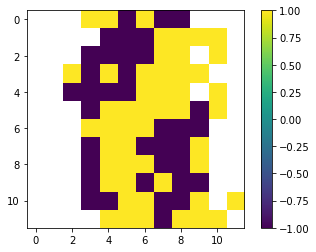

In [11]:
plt.imshow(np.sign((r_on - r_off)[:,:,0]))
plt.colorbar();

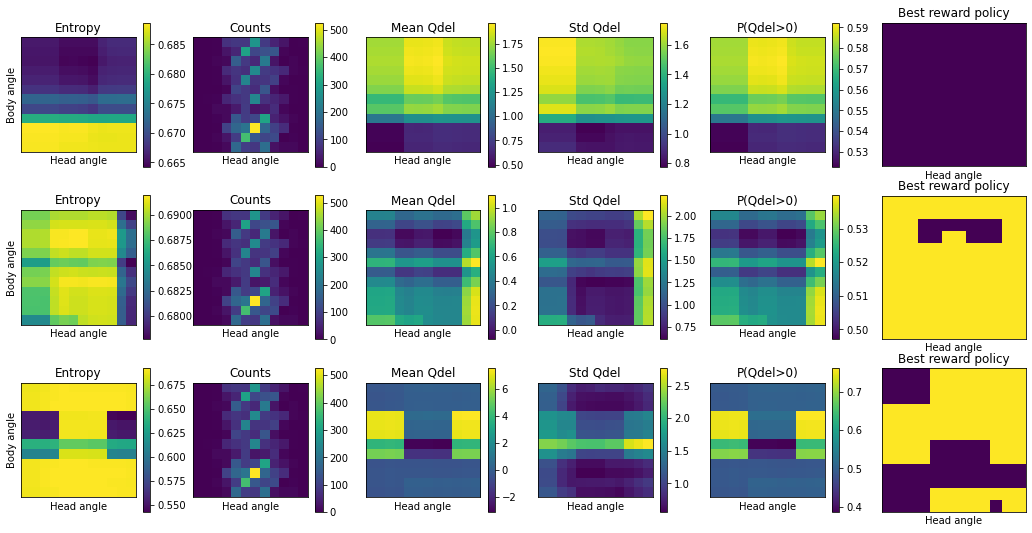

In [215]:
plot_bart_results('bart',[0,4,9],'./Data/03_29_2/')

In [43]:
trajdict2 = trajdict2.append(trajdict0)

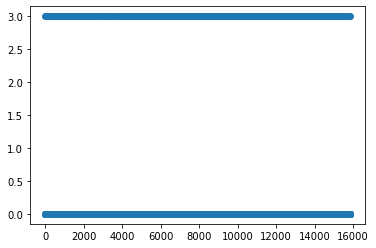

In [44]:
plt.plot(trajdict2['prev_actions'].to_numpy(),'o')

In [168]:
pt.save_for_R(trajdict,'combined.npy')

Saved as numpy for R


In [169]:
folder = 'Data/03_29_3/'
bart = np.load(f'{folder}bartcomb.npy')
bart_s = np.load(f'{folder}bartcombsig.npy')

In [170]:
bd,bmu,bsig = get_bart_stats(bart)

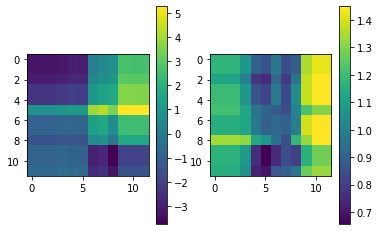

In [171]:
fig,ax = plt.subplots(1,2)
b_st = [bmu,bsig]
for i in range(2):
    img = ax[i].imshow(b_st[i])
    plt.colorbar(img,ax=ax[i])

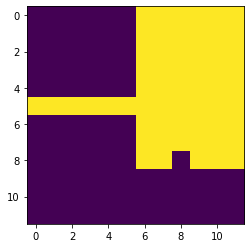

In [172]:
plt.imshow(np.sign(bmu))

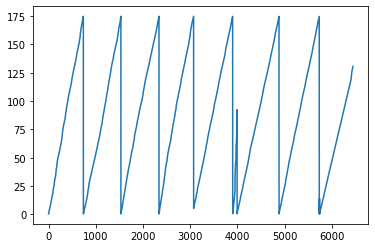

In [151]:
plt.plot(trajdict['t'])